# LangGraph + Text2SQL

![Intro1](../images/text2sql/langgraph.png)

### 유틸 설정

In [1]:
!pip install streamlit
!pip install opensearch-py
!pip install langgraph

In [2]:
import boto3
import json
import copy
from botocore.config import Config

from langchain_community.embeddings import BedrockEmbeddings
from langchain_community.utilities import SQLDatabase
from sqlalchemy import create_engine
from src.opensearch import OpenSearchHybridRetriever, OpenSearchClient


region_name = "us-west-2"
llm_model = "anthropic.claude-3-sonnet-20240229-v1:0"

engine = create_engine("sqlite:///Chinook.db")
db = SQLDatabase(engine)
DIALECT = "sqlite"

def converse_with_bedrock(sys_prompt, usr_prompt):
    temperature = 0.0
    top_p = 0.1
    top_k = 1
    inference_config = {"temperature": temperature, "topP": top_p}
    additional_model_fields = {"top_k": top_k}
    response = boto3_client.converse(
        modelId=llm_model, 
        messages=usr_prompt, 
        system=sys_prompt,
        inferenceConfig=inference_config,
        additionalModelRequestFields=additional_model_fields
    )
    return response['output']['message']['content'][0]['text']

def init_boto3_client(region: str):
    retry_config = Config(
        region_name=region,
        retries={"max_attempts": 10, "mode": "standard"}
    )
    return boto3.client("bedrock-runtime", region_name=region, config=retry_config)

def init_search_resources():  
    embedding_model = BedrockEmbeddings(model_id="amazon.titan-embed-text-v2:0", region_name=region_name, model_kwargs={"dimensions":1024})
    sql_search_client = OpenSearchClient(emb=embedding_model, index_name='example_queries', mapping_name='mappings-sql', vector="input_v", text="input", output=["input", "query"])
    table_search_client = OpenSearchClient(emb=embedding_model, index_name='schema_descriptions', mapping_name='mappings-detailed-schema', vector="table_summary_v", text="table_summary", output=["table_name", "table_summary"])

    sql_retriever = OpenSearchHybridRetriever(sql_search_client, k=10)
    table_retriever = OpenSearchHybridRetriever(table_search_client, k=10)
    return sql_search_client, table_search_client, sql_retriever, table_retriever

def get_column_description(table_name):
    query = {
        "query": {
            "match": {
                "table_name": table_name
            }
        }
    }
    response = table_search_client.conn.search(index=table_search_client.index_name, body=query)

    if response['hits']['total']['value'] > 0:
        source = response['hits']['hits'][0]['_source']
        columns = source.get('columns', [])
        if columns:
            return {col['col_name']: col['col_desc'] for col in columns}
        else:
            return {}
    else:
        return {}

def search_by_keywords(keyword):
    query = {
        "size": 10, 
        "query": {
            "nested": {
                "path": "columns",
                "query": {
                    "match": {
                        "columns.col_desc": f"{keyword}"
                    }
                },
                "inner_hits": {
                    "size": 1, 
                    "_source": ["columns.col_name", "columns.col_desc"]
                }
            }
        },
        "_source": ["table_name"]
    }
    response = table_search_client.conn.search(
        index=table_search_client.index_name,
        body=query
    )
    
    search_result = ""
    try:
        results = []
        table_names = set()  
        if 'hits' in response and 'hits' in response['hits']:
            for hit in response['hits']['hits']:
                table_name = hit['_source']['table_name']
                table_names.add(table_name)  
                for inner_hit in hit['inner_hits']['columns']['hits']['hits']:
                    column_name = inner_hit['_source']['col_name']
                    column_description = inner_hit['_source']['col_desc']
                    results.append({
                        "table_name": table_name,
                        "column_name": column_name,
                        "column_description": column_description
                    })
                    if len(results) >= 5:
                        break
                if len(results) >= 5:
                    break
        search_result += json.dumps(results, ensure_ascii=False)
    except:
        search_result += f"{keyword} not found"
    return search_result    

def create_prompt(sys_template, user_template, **kwargs):
    sys_prompt = [{"text": sys_template.format(**kwargs)}]
    usr_prompt = [{"role": "user", "content": [{"text": user_template.format(**kwargs)}]}]
    return sys_prompt, usr_prompt

boto3_client = init_boto3_client(region_name)
sql_search_client, table_search_client, sql_retriever, table_retriever = init_search_resources()

### 검색 기능 테스트

In [3]:
# 검색 키워드 예시
keyword = "사람들이 좋아하는 장르"

sql_search_result = sql_retriever.invoke(keyword, ensemble=[0.60, 0.40])
table_search_result = table_retriever.invoke(keyword, ensemble=[0.60, 0.40])

if sql_search_result:
    page_content = json.loads(sql_search_result[0].page_content)
    print("샘플 쿼리 검색 결과: ", json.dumps(page_content, indent=4, ensure_ascii=False))

if table_search_result:
    page_content = json.loads(table_search_result[0].page_content)
    print("테이블 검색 결과: ", json.dumps(page_content, indent=4, ensure_ascii=False))

샘플 쿼리 검색 결과:  {
    "input": "What tracks belong to the 'Rock' genre?",
    "query": "SELECT * FROM Track WHERE GenreId = (SELECT GenreId FROM Genre WHERE Name = 'Rock')"
}
테이블 검색 결과:  {
    "table_name": "Genre",
    "table_summary": "이 테이블은 음악 장르에 대한 정보를 제공합니다. 각 장르는 고유한 식별자(GenreId)와 이름(Name)으로 구분됩니다. \n\n이 테이블을 활용하면 다음과 같은 분석이 가능합니다:\n\n- 특정 장르에 속하는 트랙 목록 조회\n- 장르별 트랙 수 집계\n- 신규 장르 추가 및 기존 장르 정보 수정\n- 다른 테이블(예: 트랙 정보 테이블)과 조인하여 장르별 트랙 통계 분석\n\n예를 들어 특정 장르의 인기도를 파악하거나, 사용자 취향에 맞는 장르의 트랙을 추천하는 데 활용할 수 있습니다. 또한 음원 서비스에서 장르별 트랙 분류 기능을 구현하는 데에도 도움이 될 것입니다."
}


### 그래프 상태 설정

In [4]:
from typing import TypedDict

class GraphState(TypedDict):
    question: str  
    intent: str
    sample_queries: list
    readiness: str
    tables_summaries: list
    table_names: list
    table_details: list
    query_state: dict
    next_action: str
    answer: str
    dialect: str
    

### 서브그래프1 - 스키마링킹 정의

In [5]:
### Schema Linking - SubGraph1

csv_list_response_format = "Your response should be a list of comma separated values, eg: `foo, bar, baz` or `foo,bar,baz`"
json_response_format = """'The output should be formatted as a JSON instance that conforms to the JSON schema below.\n\nAs an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}\nthe object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.\n\nHere is the output schema:\n```\n{"properties": {"setup": {"title": "Setup", "description": "question to set up a joke", "type": "string"}, "punchline": {"title": "Punchline", "description": "answer to resolve the joke", "type": "string"}}, "required": ["setup", "punchline"]}\n```'"""

def analyze_intent(state: GraphState) -> GraphState:
    question = state["question"]
    sys_prompt_template = "당신은 사용자 질문의 의도를 파악하는 비서입니다. 당신의 임무는 사용자 질문을 하나로 분류하는 것입니다."
    usr_prompt_template = f"사용자 질문을 해결하기 위해 데이터베이스 조회가 필요하면 `database` 그 밖의 경우는 `general`로 응답하세요. 서두는 생략하세요. \n\n #질문: {question}"
    sys_prompt, usr_prompt = create_prompt(sys_prompt_template, usr_prompt_template, question=question)
    intent = converse_with_bedrock(sys_prompt, usr_prompt)

    return GraphState(intent=intent)

def get_sample_queries(state: GraphState) -> GraphState:
    question = state["question"]
    samples = sql_retriever.invoke(question, ensemble=[0.80, 0.20])
    page_contents = [doc.page_content for doc in samples if doc is not None]
    sample_inputs = [json.loads(content)['input'] for content in page_contents]

    sys_prompt_template = "당신은 사용자 질문에 대한 SQL 쿼리를 작성하는 유능한 데이터베이스 엔지니어입니다. 당신의 임무는 질문에 부합한 SQL 쿼리 작성에 유용한 샘플 쿼리를 선택하는 것입니다. 당신이 선택하는 샘플 쿼리는 쿼리 재활용, 스키마 참조 등에 사용될 수 있습니다."
    usr_prompt_template = "질문에 부합한 SQL 쿼리 작성을 위해 유용한 샘플 쿼리를 선택하여 중요도 순서로 정렬하여 응답하세요. 샘플 쿼리의 인덱스 번호(0부터 시작)만 응답하세요. 관련된 샘플이 없으면 빈 목록("")으로 응답하세요. \n\n #질문: {question}\n\n #샘플 쿼리:\n {sample_inputs}\n\n #형식: {csv_list_response_format}"
    sys_prompt, usr_prompt = create_prompt(sys_prompt_template, usr_prompt_template, question=question, sample_inputs=sample_inputs, csv_list_response_format=csv_list_response_format)
    sample_ids = converse_with_bedrock(sys_prompt, usr_prompt)
    try:
        if sample_ids == '""' or sample_ids.strip() == "":
            return GraphState(sample_queries=[])
        else:
            sample_ids_list = [int(id.strip()) for id in sample_ids.split(',') if id.strip().isdigit()]
            sample_queries = [json.loads(page_contents[id]) for id in sample_ids_list] if sample_ids_list else []
            return GraphState(sample_queries=sample_queries)
    except:
        return GraphState(sample_queries=[])
    
def check_readiness(state: GraphState) -> GraphState:
    question = state["question"]
    sample_queries = state["sample_queries"]
    table_details = state["table_details"]

    sys_prompt_template = "당신은 사용자 질문에 대한 SQL 쿼리를 작성하는 유능한 데이터베이스 엔지니어입니다. 당신의 임무는 주어진 DB 정보를 바탕으로, 사용자 질문에 대한 SQL 쿼리 작성이 가능한지 판단하는 것입니다."
    usr_prompt_template = "질문에 대한 SQL 쿼리를 생성하기에 충분한 정보가 제공되었는지 판단합니다. 서두는 건너뛰고, 정보가 충분하면 `Ready`, 정보가 부족하면 `Not Ready`로 응답하세요.\n\n #질문: {question}\n\n #샘플 쿼리:\n {sample_queries}\n\n #사용 가능한 테이블:\n {table_details}"
    sys_prompt, usr_prompt = create_prompt(sys_prompt_template, usr_prompt_template, question=question, sample_queries=sample_queries, table_details=table_details)
    readiness = converse_with_bedrock(sys_prompt, usr_prompt)
    
    return GraphState(readiness=readiness)

def get_relevant_tables(state: GraphState) -> GraphState:
    question = state["question"]
    tables = table_retriever.invoke(question, ensemble=[0.40, 0.60])
    page_contents = [doc.page_content for doc in tables if doc is not None]
    table_inputs = [json.loads(content)['table_summary'] for content in page_contents]

    sys_prompt_template = "당신은 사용자 요청에 맞는 SQL 쿼리를 작성하는 유능한 데이터베이스 엔지니어입니다. 당신의 임무는 SQL 쿼리 작성에 필요한 테이블을 선택하는 것입니다."
    usr_prompt_template = "사용자 요청에 맞는 SQL 쿼리를 생성하기 위해 필요한 테이블을 선택하여, 이를 중요도 순서로 정렬한 후 인덱스 번호(0부터 시작)로 응답하세요. 사용자 요청에 관련된 테이블이 없으면 빈 목록("")으로 응답하세요.\n\n #질문: {question}\n\n #테이블 정보:\n {table_inputs}\n\n #형식: {csv_list_response_format}"
    sys_prompt, usr_prompt = create_prompt(sys_prompt_template, usr_prompt_template, question=question, table_inputs=table_inputs, csv_list_response_format=csv_list_response_format)
    table_ids = converse_with_bedrock(sys_prompt, usr_prompt)
    try:
        if table_ids == '""' or table_ids.strip() == "":
            return GraphState(tables=[], table_names=[])
        else:
            table_ids_list = [int(id.strip()) for id in table_ids.split(',') if id.strip().isdigit()]
            tables = [json.loads(page_contents[id]) for id in table_ids_list] if table_ids_list else []
            table_names = [table['table_name'] for table in tables]
            return GraphState(tables=tables, table_names=table_names)
    except:
        return GraphState(tables=[], table_names=[])

def describe_schema(state: GraphState) -> GraphState:
    table_names = state["table_names"]
    table_details = []
    data = db.get_table_info_no_throw(table_names)
    
    if not isinstance(data, list):
        data = [data]
    
    for item in data:
        if isinstance(item, str):
            items = item.split('CREATE TABLE')
        else:
            items = [item]
        
        for i in range(1, len(items)):
            sub_item = 'CREATE TABLE' + items[i]
            for table_name in table_names:
                if f'CREATE TABLE "{table_name}"' in sub_item:
                    
                    parts = sub_item.split('/*', 1)
                    sql_statement = parts[0].strip()
                    
                    sample_data = "No sample data available"
                    if len(parts) > 1:
                        sample_part = parts[1].split('*/', 1)[0] 
                        sample_lines = sample_part.strip().split('\n')
                        if len(sample_lines) > 1:
                            sample_data = '\n'.join(sample_lines)
                    
                    table_desc = get_column_description(table_name) if table_search_client else {}        
                    table_detail = {
                        "table": table_name,
                        "cols": table_desc if table_desc else {},
                        "create_table_sql": sql_statement,
                        "sample_data": sample_data
                    }
                    
                    if not table_detail["cols"]:
                        print(f"No columns found for table {table_name}")
                    table_details.append(table_detail)
                    
    return GraphState(table_details=table_details)

def next_step_by_intent(state: GraphState) -> GraphState:
    return state["intent"]

def next_step_by_readiness(state: GraphState) -> GraphState:
    return state["readiness"]


### 서브그래프1 - 모듈 코드

In [6]:
### Schema Linking - SubGraph1 Modules (Dev)

def analyze_intent_dev(question):
    sys_prompt_template = "당신은 사용자 질문의 의도를 파악하는 비서입니다. 당신의 임무는 사용자 질문을 하나로 분류하는 것입니다."
    usr_prompt_template = "사용자 질문을 해결하기 위해 데이터베이스 조회가 필요하면 `database` 그 밖의 경우는 `general`로 응답하세요. \n\n #질문: {question}"
    sys_prompt, usr_prompt = create_prompt(sys_prompt_template, usr_prompt_template, question=question)
    intent = converse_with_bedrock(sys_prompt, usr_prompt)

    return intent

def get_general_answer_dev(question):
    sys_prompt_template = "당신은 사용자의 일반적인 질문에 답변하는 유능한 비서입니다. 잘 모르는 질문에는 모른다고 답변하세요."
    usr_prompt_template = "#질문: {question}"
    sys_prompt, usr_prompt = create_prompt(sys_prompt_template, usr_prompt_template, question=question)
    answer = converse_with_bedrock(sys_prompt, usr_prompt)

    return answer    

def get_sample_queries_dev(question):
    samples = sql_retriever.invoke(question, ensemble=[0.80, 0.20])
    page_contents = [doc.page_content for doc in samples if doc is not None]
    sample_inputs = [json.loads(content)['input'] for content in page_contents]

    sys_prompt_template = "당신은 사용자 질문에 대한 SQL 쿼리를 작성하는 유능한 데이터베이스 엔지니어입니다. 당신의 임무는 질문에 부합한 SQL 쿼리 작성에 유용한 샘플 쿼리를 선택하는 것입니다. 당신이 선택하는 샘플 쿼리는 쿼리 재활용, 스키마 참조 등에 사용될 수 있습니다."
    usr_prompt_template = "질문에 부합한 SQL 쿼리 작성을 위해 유용한 샘플 쿼리를 선택하여 중요도 순서로 정렬하여 응답하세요. 샘플 쿼리의 인덱스 번호(0부터 시작)만 응답하세요. 관련된 샘플이 없으면 빈 목록("")으로 응답하세요. \n\n #질문: {question}\n\n #샘플 쿼리:\n {sample_inputs}\n\n #형식: {csv_list_response_format}"
    sys_prompt, usr_prompt = create_prompt(sys_prompt_template, usr_prompt_template, question=question, sample_inputs=sample_inputs, csv_list_response_format=csv_list_response_format)
    sample_ids = converse_with_bedrock(sys_prompt, usr_prompt)
    try:
        if sample_ids == '""' or sample_ids.strip() == "":
            return []
        else:
            sample_ids_list = [int(id.strip()) for id in sample_ids.split(',') if id.strip().isdigit()]
            sample_queries = [json.loads(page_contents[id]) for id in sample_ids_list] if sample_ids_list else []
            return sample_queries
    except:
        return []
    
def check_readiness_dev(question, sample_queries, table_details):
    sys_prompt_template = "당신은 사용자 질문에 대한 SQL 쿼리를 작성하는 유능한 데이터베이스 엔지니어입니다. 당신의 임무는 주어진 DB 정보를 바탕으로, 사용자 질문에 대한 SQL 쿼리 작성이 가능한지 판단하는 것입니다."
    usr_prompt_template = "질문에 대한 SQL 쿼리를 생성하기에 충분한 정보가 제공되었는지 판단합니다. 서두는 건너뛰고, 정보가 충분하면 `Ready`, 정보가 부족하면 `Not Ready`로 응답하세요.\n\n #질문: {question}\n\n #샘플 쿼리:\n {sample_queries}\n\n #사용 가능한 테이블:\n {table_details}"
    sys_prompt, usr_prompt = create_prompt(sys_prompt_template, usr_prompt_template, question=question, sample_queries=sample_queries, table_details=table_details)
    readiness = converse_with_bedrock(sys_prompt, usr_prompt)
    
    return readiness

def get_relevant_tables_dev(question):
    tables = table_retriever.invoke(question, ensemble=[0.40, 0.60])
    page_contents = [doc.page_content for doc in tables if doc is not None]
    table_inputs = [json.loads(content)['table_summary'] for content in page_contents]
    sys_prompt_template = "당신은 사용자 요청에 맞는 SQL 쿼리를 작성하는 유능한 데이터베이스 엔지니어입니다. 당신의 임무는 SQL 쿼리 작성에 필요한 테이블을 선택하는 것입니다."
    usr_prompt_template = "사용자 요청에 맞는 SQL 쿼리를 생성하기 위해 필요한 테이블을 선택하여, 이를 중요도 순서로 정렬한 후 인덱스 번호(0부터 시작)로 응답하세요. 사용자 요청에 관련된 테이블이 없으면 빈 목록("")으로 응답하세요.\n\n #질문: {question}\n\n #테이블 정보:\n {table_inputs}\n\n #형식: {csv_list_response_format}"
    sys_prompt, usr_prompt = create_prompt(sys_prompt_template, usr_prompt_template, question=question, table_inputs=table_inputs, csv_list_response_format=csv_list_response_format)
    table_ids = converse_with_bedrock(sys_prompt, usr_prompt)
    try:
        if table_ids == '""' or table_ids.strip() == "":
            return []
        else:
            table_ids_list = [int(id.strip()) for id in table_ids.split(',') if id.strip().isdigit()]
            tables = [json.loads(page_contents[id]) for id in table_ids_list] if table_ids_list else []
            table_names = [table['table_name'] for table in tables]
            return tables, table_names
    except:
        return []

def describe_schema_dev(table_names):
    table_details = []
    data = db.get_table_info_no_throw(table_names)
    
    if not isinstance(data, list):
        data = [data]
    
    for item in data:
        if isinstance(item, str):
            items = item.split('CREATE TABLE')
        else:
            items = [item]
        
        for i in range(1, len(items)):
            sub_item = 'CREATE TABLE' + items[i]
            for table_name in table_names:
                if f'CREATE TABLE "{table_name}"' in sub_item:
                    
                    parts = sub_item.split('/*', 1)
                    sql_statement = parts[0].strip()
                    
                    sample_data = "No sample data available"
                    if len(parts) > 1:
                        sample_part = parts[1].split('*/', 1)[0] 
                        sample_lines = sample_part.strip().split('\n')
                        if len(sample_lines) > 1:
                            sample_data = '\n'.join(sample_lines)
                    
                    table_desc = get_column_description(table_name) if table_search_client else {}        
                    table_detail = {
                        "table": table_name,
                        "cols": table_desc if table_desc else {},
                        "create_table_sql": sql_statement,
                        "sample_data": sample_data
                    }
                    
                    if not table_detail["cols"]:
                        print(f"No columns found for table {table_name}")
                    table_details.append(table_detail)
    
    return table_details

### 서브그래프1 모듈 검증

In [7]:
### Schema Linking - SubGraph1 Modules (Test)

question1 = "2022년 매출 상위 10개 국가는?"
question2 = "오늘 날씨는?" 
question3 = "구매량 기준 상위 10명의 고객은?"

#===================================================================================================

#1 - analyze_intent
#analyze_intent_dev(question1)
#analyze_intent_dev(question2)

#2 - get_sample_queries
#get_sample_queries_dev(question1)
#get_sample_queries_dev(question2)

#3 - check_readiness
#sample_queries = [
#    '{"input": "What are the details of customers residing in Canada?", "query": "SELECT * FROM Customer WHERE Country = \'Canada\'"}',
#    '{"input": "How many tracks are on the album with ID 5?", "query": "SELECT COUNT(*) FROM Track WHERE AlbumId = 5"}',
#    '{"input": "What are the top 5 customers by total purchase amount?", "query": "SELECT CustomerId, SUM(Total) AS TotalPurchase FROM Invoice GROUP BY CustomerId ORDER BY TotalPurchase DESC LIMIT 5"}'
#]
#check_readiness_dev(question3, sample_queries, schema_info="")

#4 - get_relevant_tables
#get_relevant_tables_dev(question1)
#get_relevant_tables_dev(question3)

#5 - describe_schema
# table_names = ['Invoice', 'Customer']
# describe_schema_dev(table_names)

#6 - check_readiness
# table_names = ['Invoice', 'Customer']
# table_details = describe_schema_dev(table_names)
# check_readiness_dev(question3, sample_queries="", table_details=table_details)

#===================================================================================================

### 서브그래프2 - 쿼리 생성/검증/실행/재시도

In [8]:
### Query Generation & Execution - SubGraph2

initial_query_state = {
    "status": "success",
    "query": "",
    "result": "",
    "error": {
        "code": "",
        "message": "",
        "failed_step": "",
        "hint": ""
    }
}

def generate_query(state: GraphState) -> GraphState:
    dialect = DIALECT
    new_query_state = copy.deepcopy(initial_query_state)
    question = state["question"]
    sample_queries = state["sample_queries"]
    table_details = state["table_details"]

    query_state = state.get("query_state", {}) or {}
    error_info = query_state.get("error", {}) or {}
    hint = error_info.get("hint", "None")
    
    sys_prompt_template = "당신은 사용자 질문에 대한 {dialect} SQL 쿼리를 작성하는 유능한 데이터베이스 엔지니어입니다. 당신의 임무는 주어진 DB 정보를 바탕으로, 사용자 질문에 부합하는 정확한 SQL 쿼리를 작성하는 것입니다."
    usr_prompt_template = "다음 주어진 샘플 쿼리 및 스키마 정보, 과거 실패 이력을 바탕으로 DB dialect에 맞는 쿼리를 작성합니다. 서두는 생략하고 생성된 SQL 쿼리 구문만 제공하세요. \n\n #질문: {question}\n\n #샘플 쿼리:\n {sample_queries}\n\n #사용 가능한 테이블:\n {table_details}\n\n, #추가 정보 (과거 실패 이력, 추가 획득한 정보 등):\n {hint}"
    sys_prompt, usr_prompt = create_prompt(sys_prompt_template, usr_prompt_template, question=question, dialect=dialect, sample_queries=sample_queries, table_details=table_details, hint=hint)
    generated_query = converse_with_bedrock(sys_prompt, usr_prompt)

    new_query_state["query"] = generated_query

    return GraphState(query_state=new_query_state)

def validate_query(state: GraphState) -> GraphState:
    dialect = DIALECT
    question = state["question"]
    query_state = copy.deepcopy(state["query_state"])
    query = query_state["query"]
    
    explain_statements = {
        'mysql': "EXPLAIN {query}",
        'mariadb': "EXPLAIN {query}",
        'sqlite': "EXPLAIN QUERY PLAN {query}",
        'oracle': "EXPLAIN PLAN FOR\n{query}\n\nSELECT * FROM TABLE(DBMS_XPLAN.DISPLAY);",
        'postgresql': "EXPLAIN ANALYZE {query}",
        'postgres': "EXPLAIN ANALYZE {query}",
        'presto': "EXPLAIN ANALYZE {query}",
        'sqlserver': "SET STATISTICS PROFILE ON; {query}; SET STATISTICS PROFILE OFF;"
    }
    
    if dialect.lower() not in explain_statements:
        query_plan = " "
    else:
        try:
            explain_query = explain_statements[dialect.lower()].format(query=query)
            query_plan = db.run(explain_query)
        except Exception as e:
            query_state["status"] = "error"
            query_state["error"]["code"] = "E01"
            query_state["error"]["message"] = f"An error occurred while executing the EXPLAIN query: {str(e)}"
            query_state["error"]["failed_step"] = "validation"
            query_state["query"] = query
            return GraphState(query_state=query_state)

    sys_prompt_template = "당신은 사용자 질문에 대한 기존 {dialect} SQL 쿼리를 검토하고, 필요 시 최적화하는 데이터베이스 전문가입니다. 당신의 임무는 주어진 SQL 쿼리 및 추가 정보를 바탕으로 쿼리의 정합성, 최적화 가능성을 검토하고, 이에 입각한 최종 쿼리를 제공하는 것입니다. "
    usr_prompt_template = "사용자의 질문에 맞춰 쿼리에 alias를 추가해주세요. 기존 SQL 쿼리에서 사용되지 않았던 테이블, 컬럼을 추가하는 것은 허용되지 않습니다. 서두는 생략하고 생성된 SQL 쿼리 구문만 제공하세요. \n\n #질문: {question}\n\n #기존 쿼리:\n {query}\n\n #쿼리 플랜:\n {query_plan}"
    sys_prompt, usr_prompt = create_prompt(sys_prompt_template, usr_prompt_template, question=question, dialect=dialect, query=query, query_plan=query_plan)
    validated_query = converse_with_bedrock(sys_prompt, usr_prompt)
    query_state["query"] = validated_query

    return GraphState(query_state=query_state)

def execute_query(state: GraphState) -> GraphState:
    query_state = copy.deepcopy(state["query_state"])
    query = query_state["query"]
    try:
        query_state["result"] = db.run(query)
    except Exception as e:
        query_state["status"] = "error"
        query_state["error"]["code"] = "E02"
        query_state["error"]["message"] = f"An error occurred while executing the validated query: {str(e)}"
        query_state["error"]["failed_step"] = "execution"
        return GraphState(query_state=query_state)
    return GraphState(query_state=query_state)
    
def handle_failure(state: GraphState) -> GraphState:
    query_state = copy.deepcopy(state["query_state"])
    query = query_state['query']
    message = query_state['error']['message']
    sys_prompt_template = "당신은 SQL 쿼리의 실패를 처리하는 유능한 데이터베이스 엔지니어입니다. 당신의 임무는 주어진 SQL 쿼리의 실패 원인을 파악하여, 문제 해결을 위한 다음 작업을 결정하는 것입니다."
    usr_prompt_template = "주어진 SQL 쿼리의 실패 메시지를 바탕으로 다음 중 하나의 원인(`failure_type`)과 해결을 위한 실마리(`hint`)를 함께 제공합니다.\n 다음은 failure_type의 선택 예시입니다.\n부정확한 쿼리 구문 작성: `syntax_check`\n스키마 불일치: `schema_check`\nDB 외부요인(권한, 연결 문제 등): `stop`\nDB의 일시적 오동작(쿼리 재실행 필요): `retry`\n\n#실패 쿼리: {query}\n\n#실패 메시지: {message}\n\n#형식: {json_response_format}"
    sys_prompt, usr_prompt = create_prompt(sys_prompt_template, usr_prompt_template, query=query, message=message, json_response_format=json_response_format)
    result = converse_with_bedrock(sys_prompt, usr_prompt)
    json_result = json.loads(result)

    query_state["hint"] = json_result["hint"]
    return GraphState(next_action=json_result["failure_type"], query_state=query_state)

def get_relevant_columns(state: GraphState) -> GraphState:
    query_state = copy.deepcopy(state["query_state"])
    question = state["question"]
    query = query_state["query"]
    message = query_state['error']['message']
    sys_prompt_template = "당신은 SQL 쿼리의 실패를 처리하는 유능한 데이터베이스 엔지니어입니다. 당신의 임무는 앞서 발생한 쿼리 실패를 해결하기 위해 스키마를 재탐색 하는 것입니다."
    usr_prompt_template = "사용자 질문과 주어진 실패 메시지를 바탕으로 쿼리 재탐색에 적절한 키워드를 제공하세요. 서두는 생략하고 키워드만 형식에 맞춰 응답하세요. \n\n #사용자 질문: {question}\n\n#이전 실패 쿼리: {query}\n\n메시지: {message}\n\n#형식: {csv_list_response_format}"
    sys_prompt, usr_prompt = create_prompt(sys_prompt_template, usr_prompt_template, question=question, query=query, message=message, csv_list_response_format=csv_list_response_format)
    keywords = converse_with_bedrock(sys_prompt, usr_prompt)
    return keywords

def next_step_by_query_state(state:GraphState) -> GraphState:
    return state["query_state"]["status"]

def next_step_by_next_action(state:GraphState) -> GraphState:
    return state["next_action"]


### 서브그래프2 - 모듈 코드

In [9]:
def generate_query_dev(question, dialect, sample_queries, table_details, hint):
    dialect = dialect
    query_state = copy.deepcopy(initial_query_state)
    question = question
    sample_queries = sample_queries
    table_details = table_details
    hint = hint
    
    sys_prompt_template = "당신은 사용자 질문에 대한 {dialect} SQL 쿼리를 작성하는 유능한 데이터베이스 엔지니어입니다. 당신의 임무는 주어진 DB 정보를 바탕으로, 사용자 질문에 부합하는 정확한 SQL 쿼리를 작성하는 것입니다."
    usr_prompt_template = "다음 주어진 샘플 쿼리 및 스키마 정보, 과거 실패 이력을 바탕으로 DB dialect에 맞는 쿼리를 작성합니다. 서두는 생략하고 생성된 SQL 쿼리 구문만 제공하세요. \n\n #질문: {question}\n\n #샘플 쿼리:\n {sample_queries}\n\n #사용 가능한 테이블:\n {table_details}\n\n, #추가 정보 (과거 실패 이력, 추가 획득한 정보 등):\n {hint}"
    sys_prompt, usr_prompt = create_prompt(sys_prompt_template, usr_prompt_template, question=question, dialect=dialect, sample_queries=sample_queries, table_details=table_details, hint=hint)
    generated_query = converse_with_bedrock(sys_prompt, usr_prompt)

    query_state["query"] = generated_query
    return copy.deepcopy(query_state)

def validate_query_dev(question, dialect, query_state):
    question = question
    query_state = copy.deepcopy(query_state)
    query = query_state["query"]
    
    explain_statements = {
        'mysql': "EXPLAIN {query}",
        'mariadb': "EXPLAIN {query}",
        'sqlite': "EXPLAIN QUERY PLAN {query}",
        'oracle': "EXPLAIN PLAN FOR\n{query}\n\nSELECT * FROM TABLE(DBMS_XPLAN.DISPLAY);",
        'postgresql': "EXPLAIN ANALYZE {query}",
        'postgres': "EXPLAIN ANALYZE {query}",
        'presto': "EXPLAIN ANALYZE {query}",
        'sqlserver': "SET STATISTICS PROFILE ON; {query}; SET STATISTICS PROFILE OFF;"
    }
    
    if dialect.lower() not in explain_statements:
        query_plan = " "
    else:
        try:
            explain_query = explain_statements[dialect.lower()].format(query=query)
            query_plan = db.run(explain_query)
        except Exception as e:
            query_state["status"] = "error"
            query_state["error"]["code"] = "E01"
            query_state["error"]["message"] = f"An error occurred while executing the EXPLAIN query: {str(e)}"
            query_state["error"]["failed_step"] = "validation"
            query_state["query"] = query
            return copy.deepcopy(query_state)

    sys_prompt_template = "당신은 사용자 질문에 대한 기존 {dialect} SQL 쿼리를 검토하고, 필요 시 최적화하는 데이터베이스 전문가입니다. 당신의 임무는 주어진 SQL 쿼리 및 추가 정보를 바탕으로 쿼리의 정합성, 최적화 가능성을 검토하고, 이에 입각한 최종 쿼리를 제공하는 것입니다. "
    usr_prompt_template = "사용자의 질문에 맞춰 쿼리에 alias를 추가해주세요. 기존 SQL 쿼리에서 사용되지 않았던 테이블, 컬럼을 추가하는 것은 허용되지 않습니다. 서두는 생략하고 생성된 SQL 쿼리 구문만 제공하세요. \n\n #질문: {question}\n\n #기존 쿼리:\n {query}\n\n #쿼리 플랜:\n {query_plan}"
    sys_prompt, usr_prompt = create_prompt(sys_prompt_template, usr_prompt_template, question=question, dialect=dialect, query=query, query_plan=query_plan)
    validated_query = converse_with_bedrock(sys_prompt, usr_prompt)
    query_state["query"] = validated_query

    return copy.deepcopy(query_state)

def execute_query_dev(query_state):
    query_state = copy.deepcopy(query_state)
    query = query_state["query"]
    try:
        query_state["result"] = db.run(query)
    except Exception as e:
        query_state["status"] = "error"
        query_state["error"]["code"] = "E02"
        query_state["error"]["message"] = f"An error occurred while executing the validated query: {str(e)}"
        query_state["error"]["failed_step"] = "execution"
        return copy.deepcopy(query_state)
    return copy.deepcopy(query_state)
    
def handle_failure_dev(query_state):
    query_state = copy.deepcopy(query_state)
    query = query_state['query']
    message = query_state['error']['message']
    sys_prompt_template = "당신은 SQL 쿼리의 실패를 처리하는 유능한 데이터베이스 엔지니어입니다. 당신의 임무는 주어진 SQL 쿼리의 실패 원인을 파악하여, 문제 해결을 위한 다음 작업을 결정하는 것입니다."
    usr_prompt_template = "주어진 SQL 쿼리의 실패 메시지를 바탕으로 다음 중 하나의 원인(`failure_type`)과 해결을 위한 실마리(`hint`)를 함께 제공합니다.\n 다음은 failure_type의 선택 예시입니다.\n부정확한 쿼리 구문 작성: `syntax_check`\n스키마 불일치: `schema_check`\nDB 외부요인(권한, 연결 문제 등): `stop`\nDB의 일시적 오동작(쿼리 재실행 필요): `retry`\n\n#실패 쿼리: {query}\n\n#실패 메시지: {message}\n\n#형식: {json_response_format}"
    sys_prompt, usr_prompt = create_prompt(sys_prompt_template, usr_prompt_template, query=query, message=message, json_response_format=json_response_format)
    result = converse_with_bedrock(sys_prompt, usr_prompt)
    json_result = json.loads(result)

    query_state["hint"] = json_result["hint"]
    return json_result["failure_type"], copy.deepcopy(query_state)

def get_relevant_columns_dev(question, query_state):
    query_state = copy.deepcopy(query_state)
    question = question
    query = query_state["query"]
    message = query_state['error']['message']
    sys_prompt_template = "당신은 SQL 쿼리의 실패를 처리하는 유능한 데이터베이스 엔지니어입니다. 당신의 임무는 사용자 질문과 실패 메시지를 참고하여, 쿼리 수정을 위한 스키마 검색 키워드(English)를 5개 이내로 제공하는 것입니다."
    usr_prompt_template = "키워드는 구체적 컬럼 이름이 아니라, 컬럼을 설명하거나 사용자 질문에 대응하는 일반적 단어를 의미합니다. \n\n #사용자 질문: {question}\n\n#이전 실패 쿼리: {query}\n\n메시지: {message}\n\n#형식: {csv_list_response_format}"
    sys_prompt, usr_prompt = create_prompt(sys_prompt_template, usr_prompt_template, question=question, query=query, message=message, csv_list_response_format=csv_list_response_format)
    response = converse_with_bedrock(sys_prompt, usr_prompt)
    
    keyword_list = [keyword.strip() for keyword in response.strip('`').split(',')]
    
    query_state["hint"] += "\n\n#추가 스키마 정보:\n"
    for keyword in keyword_list:
        query_state["hint"] += search_by_keywords(keyword)
        query_state["hint"] += "\n"

    return copy.deepcopy(query_state)
    

### 서브그래프2 - 모듈 검증

In [10]:
#===================================================================================================

#7 - generate_query
# question = "2022년 매출 상위 10개 국가는?"
# sample_queries =  [{'input': 'What are the top 5 customers by total purchase amount?',
#   'query': 'SELECT CustomerId, SUM(Total) AS TotalPurchase FROM Invoice GROUP BY CustomerId ORDER BY TotalPurchase DESC LIMIT 5'}]
# table_details = [{'table': 'Customer',
#   'cols': {'CustomerId': 'Primary key, unique customer identifier.',
#    'FirstName': 'First name of the customer.',
#    'LastName': 'Last name of the customer.',
#    'Company': 'Company of the customer.',
#    'Address': 'Address of the customer.',
#    'City': 'City of the customer.',
#    'State': 'State of the customer.',
#    'Country': 'Country of the customer.',
#    'PostalCode': 'Postal code of the customer.',
#    'Phone': 'Phone number of the customer.',
#    'Fax': 'Fax number of the customer.',
#    'Email': 'Email address of the customer.',
#    'SupportRepId': 'Foreign key that references the employee who supports this customer.'},
#   'create_table_sql': 'CREATE TABLE "Customer" (\n\t"CustomerId" INTEGER NOT NULL, \n\t"FirstName" NVARCHAR(40) NOT NULL, \n\t"LastName" NVARCHAR(20) NOT NULL, \n\t"Company" NVARCHAR(80), \n\t"Address" NVARCHAR(70), \n\t"City" NVARCHAR(40), \n\t"State" NVARCHAR(40), \n\t"Country" NVARCHAR(40), \n\t"PostalCode" NVARCHAR(10), \n\t"Phone" NVARCHAR(24), \n\t"Fax" NVARCHAR(24), \n\t"Email" NVARCHAR(60) NOT NULL, \n\t"SupportRepId" INTEGER, \n\tPRIMARY KEY ("CustomerId"), \n\tFOREIGN KEY("SupportRepId") REFERENCES "Employee" ("EmployeeId")\n)',
#   'sample_data': '3 rows from Customer table:\nCustomerId\tFirstName\tLastName\tCompany\tAddress\tCity\tState\tCountry\tPostalCode\tPhone\tFax\tEmail\tSupportRepId\n1\tLuís\tGonçalves\tEmbraer - Empresa Brasileira de Aeronáutica S.A.\tAv. Brigadeiro Faria Lima, 2170\tSão José dos Campos\tSP\tBrazil\t12227-000\t+55 (12) 3923-5555\t+55 (12) 3923-5566\tluisg@embraer.com.br\t3\n2\tLeonie\tKöhler\tNone\tTheodor-Heuss-Straße 34\tStuttgart\tNone\tGermany\t70174\t+49 0711 2842222\tNone\tleonekohler@surfeu.de\t5\n3\tFrançois\tTremblay\tNone\t1498 rue Bélanger\tMontréal\tQC\tCanada\tH2G 1A7\t+1 (514) 721-4711\tNone\tftremblay@gmail.com\t3'},
#  {'table': 'Invoice',
#   'cols': {'InvoiceId': 'Primary key, unique identifier for the invoice.',
#    'CustomerId': 'Foreign key that references the customer associated with this invoice.',
#    'InvoiceDate': 'Date when the invoice was issued.',
#    'BillingAddress': 'Billing address on the invoice.',
#    'BillingCity': 'Billing city on the invoice.',
#    'BillingState': 'Billing state on the invoice.',
#    'BillingCountry': 'Billing country on the invoice.',
#    'BillingPostalCode': 'Billing postal code on the invoice.',
#    'Total': 'Total amount of the invoice.'},
#   'create_table_sql': 'CREATE TABLE "Invoice" (\n\t"InvoiceId" INTEGER NOT NULL, \n\t"CustomerId" INTEGER NOT NULL, \n\t"InvoiceDate" DATETIME NOT NULL, \n\t"BillingAddress" NVARCHAR(70), \n\t"BillingCity" NVARCHAR(40), \n\t"BillingState" NVARCHAR(40), \n\t"BillingCountry" NVARCHAR(40), \n\t"BillingPostalCode" NVARCHAR(10), \n\t"Total" NUMERIC(10, 2) NOT NULL, \n\tPRIMARY KEY ("InvoiceId"), \n\tFOREIGN KEY("CustomerId") REFERENCES "Customer" ("CustomerId")\n)',
#   'sample_data': '3 rows from Invoice table:\nInvoiceId\tCustomerId\tInvoiceDate\tBillingAddress\tBillingCity\tBillingState\tBillingCountry\tBillingPostalCode\tTotal\n1\t2\t2021-01-01 00:00:00\tTheodor-Heuss-Straße 34\tStuttgart\tNone\tGermany\t70174\t1.98\n2\t4\t2021-01-02 00:00:00\tUllevålsveien 14\tOslo\tNone\tNorway\t0171\t3.96\n3\t8\t2021-01-03 00:00:00\tGrétrystraat 63\tBrussels\tNone\tBelgium\t1000\t5.94'}]
# generate_query_dev(question=question, dialect=dialect, sample_queries=sample_queries, table_details=table_details, hint="None")

#8 - validate_query
# question = "2022년 매출 상위 10개 국가는?"
# query_state = {'status': 'success',
#  'query': "SELECT BillingCountry, SUM(Total) AS TotalSales\nFROM Invoice\nWHERE InvoiceDate BETWEEN '2022-01-01' AND '2022-12-31'\nGROUP BY BillingCountry\nORDER BY TotalSales DESC\nLIMIT 10;",
#  'result': '',
#  'error': {'code': '', 'message': '', 'failed_step': '', 'hint': 'None'}}

# validate_query_dev(question, dialect, query_state)

#9 - execute_query
# query_state = {'status': 'success',
#  'query': "SELECT BillingCountry AS Country, SUM(Total) AS TotalSales\nFROM Invoice i\nWHERE i.InvoiceDate BETWEEN '2022-01-01' AND '2022-12-31'\nGROUP BY Country\nORDER BY TotalSales DESC\nLIMIT 10;",
#  'result': '',
#  'error': {'code': '', 'message': '', 'failed_step': '', 'hint': 'None'}}
# execute_query_dev(query_state)

#10 - handle_failure
# query_state_type1 = {'status': 'error',
#  'query': "SELECT Billing AS Country, SUM(Total) AS TotalSales\nFROM Invoice i\nWHERE i.InvoiceDate BETWEEN '2022-01-01' AND '2022-12-31'\nGROUP BY Country\nORDER BY TotalSales DESC\nLIMIT 10;",
#  'result': '',
#  'error': {'code': 'E02',
#   'message': "An error occurred while executing the validated query: (sqlite3.OperationalError) no such column: Billing\n[SQL: SELECT Billing AS Country, SUM(Total) AS TotalSales\nFROM Invoice i\nWHERE i.InvoiceDate BETWEEN '2022-01-01' AND '2022-12-31'\nGROUP BY Country\nORDER BY TotalSales DESC\nLIMIT 10;]\n(Background on this error at: https://sqlalche.me/e/20/e3q8)",
#   'failed_step': 'execution',
#   'hint': "None"}}
# handle_failure_dev(query_state_type1)

# query_state_type2 = {'status': 'error',
#  'query': "SELECTS BillingCountry AS Country, SUM(Total) AS TotalSales\nFROM Invoice i\nWHERE i.InvoiceDate BETWEEN '2022-01-01' AND '2022-12-31'\nGROUP BY Country\nORDER BY TotalSales DESC\nLIMIT 10;",
#  'result': '',
#  'error': {'code': 'E02',
#   'message': 'An error occurred while executing the validated query: (sqlite3.OperationalError) near "SELECTS": syntax error\n[SQL: SELECTS BillingCountry AS Country, SUM(Total) AS TotalSales\nFROM Invoice i\nWHERE i.InvoiceDate BETWEEN \'2022-01-01\' AND \'2022-12-31\'\nGROUP BY Country\nORDER BY TotalSales DESC\nLIMIT 10;]\n(Background on this error at: https://sqlalche.me/e/20/e3q8)',
#   'failed_step': 'execution',
#   'hint': 'None'}}
# handle_failure(query_state_type2)

#11 - get_relevant_column
# question = "2022년 매출 상위 10개 국가는?"
# query_state = {'status': 'error',
#   'query': "SELECT Country AS Country, SUM(Total) AS TotalSales\nFROM Invoice i\nWHERE i.InvoiceDate BETWEEN '2022-01-01' AND '2022-12-31'\nGROUP BY Country\nORDER BY TotalSales DESC\nLIMIT 10;",
#   'result': '',
#   'error': {'code': 'E02',
#    'message': "An error occurred while executing the validated query: (sqlite3.OperationalError) no such column: Country\n[SQL: SELECT Billing AS Country, SUM(Total) AS TotalSales\nFROM Invoice i\nWHERE i.InvoiceDate BETWEEN '2022-01-01' AND '2022-12-31'\nGROUP BY Country\nORDER BY TotalSales DESC\nLIMIT 10;]\n(Background on this error at: https://sqlalche.me/e/20/e3q8)",
#    'failed_step': 'execution',
#    'hint': 'None'},
#   'hint': "열 이름 'Country'는 Invoice 테이블에 존재하지 않습니다."}

# get_relevant_columns_dev(question, query_state)

### 답변 생성 노드

In [11]:
def get_general_answer(state: GraphState) -> GraphState:
    question = state["question"]
    sys_prompt_template = "당신은 사용자의 일반적인 질문에 답변하는 유능한 비서입니다. 잘 모르는 주제에 대한 질문에 대해서는 모른다고 답변하세요."
    usr_prompt_template = "#질문: {question}"
    sys_prompt, usr_prompt = create_prompt(sys_prompt_template, usr_prompt_template, question=question)
    answer = converse_with_bedrock(sys_prompt, usr_prompt)

    return GraphState(answer=answer)

def get_database_answer(state: GraphState) -> GraphState:
    question = state["question"]
    query_state = state["query_state"]
    query = query_state["query"]
    data = query_state["result"]
    failed_step = query_state["error"]["failed_step"]
    message = query_state["error"]["message"]
    sys_prompt_template = "당신은 데이터베이스의 정보를 바탕으로 사용자의 질문에 답변하는 유능한 비서입니다. 당신의 임무는 주어진 참고정보를 참고하여, 사용자의 질문에 성실히 답변하는 것입니다."
    if query_state["status"] == "success":
        usr_prompt_template = "답변에는 사용된 쿼리, 데이터프레임(Markdown Table), 질문에 대한 간단한 답변을 포함해야 합니다. \n\n#질문: {question}\n\n#사용된 쿼리: {query}\n\n#데이터: {data}\n\n"
        sys_prompt, usr_prompt = create_prompt(sys_prompt_template, usr_prompt_template, question=question, query=query, data=data)
    else:
        usr_prompt_template = "다음에는 사용자 질문에 대한 쿼리 수행에 실패한 기록이 주어집니다. 이를 바탕으로 요청 처리에 실패한 이유를 설명하세요.\n\n#질문: {question}\n\n#사용된 쿼리: {query}\n\n#실패 단계: {failed_step}\n\n#에러메시지: {message}\n\n"
        sys_prompt, usr_prompt = create_prompt(sys_prompt_template, usr_prompt_template, question=question, query=query, failed_step=failed_step, message=message)
    
    answer = converse_with_bedrock(sys_prompt, usr_prompt)
    return GraphState(answer=answer)


### 답변 생성 - 모듈

In [12]:
def get_database_answer_dev(question, query_state) -> GraphState:
    question = question
    query_state = query_state
    query = query_state["query"]
    data = query_state["result"]
    failed_step = query_state["error"]["failed_step"]
    message = query_state["error"]["message"]
    sys_prompt_template = "당신은 데이터베이스의 정보를 바탕으로 사용자의 질문에 답변하는 유능한 비서입니다. 당신의 임무는 주어진 참고정보를 참고하여, 사용자의 질문에 성실히 답변하는 것입니다."
    if query_state["status"] == "success":
        usr_prompt_template = "답변에는 사용된 쿼리(Markdown Codeblock), 데이터프레임(Markdown Table), 질문에 대한 간단한 답변을 포함해야 합니다. \n\n#질문: {question}\n\n#사용된 쿼리: {query}\n\n#데이터: {data}\n\n"
        sys_prompt, usr_prompt = create_prompt(sys_prompt_template, usr_prompt_template, question=question, query=query, data=data)
    else:
        usr_prompt_template = "다음에는 사용자 질문에 대한 쿼리 수행에 실패한 기록이 주어집니다. 이를 바탕으로 요청 처리에 실패한 이유를 설명하세요.\n\n#질문: {question}\n\n#사용된 쿼리: {query}\n\n#실패 단계: {failed_step}\n\n#에러메시지: {message}\n\n"
        sys_prompt, usr_prompt = create_prompt(sys_prompt_template, usr_prompt_template, question=question, query=query, failed_step=failed_step, message=message)
    
    answer = converse_with_bedrock(sys_prompt, usr_prompt)
    return GraphState(answer=answer)

### 답변 생성 - 검증

In [13]:
# question = "2022년 매출 상위 10개 국가는?"
# query_state = {'status': 'success',
#  'query': "SELECT BillingCountry AS Country, SUM(Total) AS TotalSales\nFROM Invoice i\nWHERE i.InvoiceDate BETWEEN '2022-01-01' AND '2022-12-31'\nGROUP BY Country\nORDER BY TotalSales DESC\nLIMIT 10;",
#  'result': "[('USA', 102.98), ('Canada', 76.26), ('Brazil', 41.6), ('France', 39.6), ('Hungary', 32.75), ('United Kingdom', 30.689999999999998), ('Austria', 27.77), ('Germany', 25.74), ('Chile', 17.91), ('India', 17.83)]",
#  'error': {'code': '', 'message': '', 'failed_step': '', 'hint': 'None'}}

# answer = get_database_answer_dev(question, query_state)
# print(answer)

### LangGraph 워크플로 그래프 생성 

In [17]:
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver

workflow = StateGraph(GraphState)

# Global Nodes
workflow.add_node("analyze_intent", analyze_intent)
workflow.add_node("get_general_answer", get_general_answer)
workflow.add_node("get_database_answer", get_database_answer)
workflow.set_entry_point("analyze_intent")

# SubGraph1 Nodes - Schema Linking
workflow.add_node("get_sample_queries", get_sample_queries)
workflow.add_node("check_readiness", check_readiness)
workflow.add_node("get_relevant_tables", get_relevant_tables)
workflow.add_node("describe_schema", describe_schema)

# SubGraph2 Nodes - Query Generation & Execution
workflow.add_node("generate_query", generate_query)
workflow.add_node("validate_query", validate_query)
workflow.add_node("execute_query", execute_query)
workflow.add_node("handle_failure", handle_failure)
workflow.add_node("get_relevant_columns", get_relevant_columns)

# Edge from Entry to SubGraph1
workflow.add_conditional_edges(
    "analyze_intent",
    next_step_by_intent,
    {
        "database": "get_sample_queries",
        "general": "get_general_answer",
    }
)

# Edges in SubGraph1
workflow.add_edge("get_sample_queries", "check_readiness")
workflow.add_conditional_edges(
    "check_readiness"    ,
    next_step_by_readiness,
    {
        "Ready": "generate_query",
        "Not Ready": "get_relevant_tables"
    }
)
workflow.add_edge("get_relevant_tables", "describe_schema")
workflow.add_edge("describe_schema", "check_readiness")

# Edges in SubGraph2
workflow.add_edge("generate_query", "validate_query")
workflow.add_conditional_edges(
    "validate_query"    ,
    next_step_by_query_state,
    {
        "success": "execute_query",
        "error": "handle_failure"
    }
)
workflow.add_conditional_edges(
    "execute_query"    ,
    next_step_by_query_state,
    {
        "success": "get_database_answer",
        "error": "handle_failure"
    }
)
workflow.add_conditional_edges(
    "handle_failure"    ,
    next_step_by_next_action,
    {
        "schema_check": "get_relevant_columns",
        "syntax_check": "generate_query",
        "retry": "validate_query",
        "stop": "get_database_answer"
    }
)
workflow.add_edge("get_relevant_columns", "generate_query")

# Edges to END
workflow.add_edge("get_general_answer", END)
workflow.add_edge("get_database_answer", END)

memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

### LangGraph 워크플로 그래프 시각화

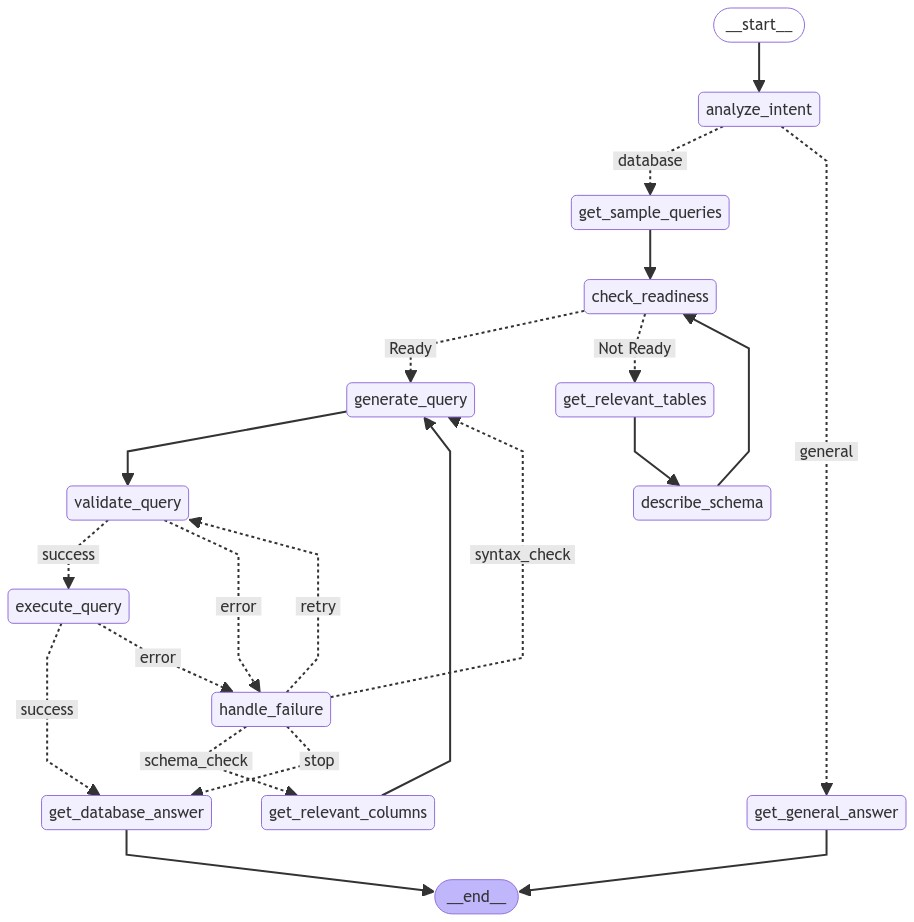

In [18]:
from IPython.display import Image, display

try:
    display(
        Image(app.get_graph(xray=True).draw_mermaid_png())
    )  # 실행 가능한 객체의 그래프를 mermaid 형식의 PNG로 그려서 표시합니다. 
       # xray=True는 추가적인 세부 정보를 포함합니다.
except:
    # 이 부분은 추가적인 의존성이 필요하며 선택적으로 실행됩니다.
    pass

### LangGraph 워크플로 End-to-End 테스트 (draft)

In [19]:
import pprint
from langgraph.errors import GraphRecursionError
from langchain_core.runnables import RunnableConfig

config = RunnableConfig(recursion_limit=100, configurable={"thread_id": "TODO"})
inputs = GraphState(question="2022년 매출 상위 10개 국가는?")

pp = pprint.PrettyPrinter(width=200, compact=True)

try:
    for output in app.stream(inputs, config=config):
        for key, value in output.items():
            print(f"\n🔹 [NODE] {key}")
            print("=" * 80)
            for k, v in value.items():
                print(f"📌 {k}:")
                pp.pprint(v)
            print("=" * 80)
except GraphRecursionError as e:
    print(f"⚠️ Recursion limit reached: {e}")


🔹 [NODE] analyze_intent
📌 intent:
'database'

🔹 [NODE] get_sample_queries
📌 sample_queries:
[{'input': 'What are the details of customers residing in Canada?', 'query': "SELECT * FROM Customer WHERE Country = 'Canada'"},
 {'input': 'How many tracks are on the album with ID 5?', 'query': 'SELECT COUNT(*) FROM Track WHERE AlbumId = 5'},
 {'input': 'What are the top 5 customers by total purchase amount?', 'query': 'SELECT CustomerId, SUM(Total) AS TotalPurchase FROM Invoice GROUP BY CustomerId ORDER BY TotalPurchase DESC LIMIT 5'}]

🔹 [NODE] check_readiness
📌 readiness:
'Not Ready'

🔹 [NODE] get_relevant_tables
📌 table_names:
['Employee', 'Invoice', 'Album']

🔹 [NODE] describe_schema
📌 table_details:
[{'cols': {'AlbumId': 'Primary key, unique identifier for the album.', 'ArtistId': 'Foreign key that references the artist of the album.', 'Title': 'Title of the album.'},
  'create_table_sql': 'CREATE TABLE "Album" (\n'
                      '\t"AlbumId" INTEGER NOT NULL, \n'
              

In [20]:
import pprint
from langgraph.errors import GraphRecursionError
from langchain_core.runnables import RunnableConfig

config = RunnableConfig(recursion_limit=100, configurable={"thread_id": "TODO"})
inputs = GraphState(question="AWS에 대해 설명해줘")

pp = pprint.PrettyPrinter(width=200, compact=True)

try:
    for output in app.stream(inputs, config=config):
        for key, value in output.items():
            print(f"\n🔹 [NODE] {key}")
            print("=" * 80)
            for k, v in value.items():
                print(f"📌 {k}:")
                pp.pprint(v)
            print("=" * 80)
except GraphRecursionError as e:
    print(f"⚠️ Recursion limit reached: {e}")


🔹 [NODE] analyze_intent
📌 intent:
'general'

🔹 [NODE] get_general_answer
📌 answer:
('AWS(Amazon Web Services)는 아마존에서 제공하는 클라우드 컴퓨팅 서비스입니다. 다양한 클라우드 기반 서비스를 제공하여 기업과 개발자들이 손쉽게 클라우드 환경을 구축하고 운영할 수 있도록 돕습니다.\n'
 '\n'
 '주요 서비스는 다음과 같습니다:\n'
 '\n'
 '1. 컴퓨팅 서비스(EC2, Lambda, ECS 등): 가상 서버, 컨테이너, 서버리스 컴퓨팅 등을 제공합니다.\n'
 '\n'
 '2. 스토리지 서비스(S3, EBS, Glacier 등): 객체 스토리지, 블록 스토리지, 데이터 아카이빙 등의 스토리지 솔루션을 제공합니다.\n'
 '\n'
 '3. 데이터베이스 서비스(RDS, DynamoDB, Redshift 등): 관계형, NoSQL, 데이터웨어하우스 등 다양한 데이터베이스 서비스를 제공합니다.\n'
 '\n'
 '4. 네트워킹 서비스(VPC, CloudFront, Route53 등): 가상 네트워크, CDN, DNS 등의 네트워킹 기능을 제공합니다.\n'
 '\n'
 '5. 개발자 도구(CodeCommit, CodeBuild, CodeDeploy 등): 코드 저장소, CI/CD, 배포 자동화 등의 개발 도구를 제공합니다.\n'
 '\n'
 '6. 관리 도구(CloudWatch, CloudFormation, CloudTrail 등): 모니터링, 자동화된 리소스 프로비저닝, 로깅 등의 관리 기능을 제공합니다.\n'
 '\n'
 'AWS는 글로벌 데이터 센터를 통해 높은 가용성과 확장성을 제공하며, 사용한 만큼만 과금되는 페이-애즈-유-고(Pay-as-you-go) 모델을 사용합니다.')
